In [1]:
import rioxarray as rio
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import joblib
from rasterio.enums import Resampling

# Load explanatory variables from .tif file
explanatory_vars = rio.open_rasterio('./working_dir/median_pixels_2018-06-01_2018-08-31.tif')

# Load target variable
target_var = rio.open_rasterio('./working_dir/labels/labels_truefalse_10m.tif')

explanatory_vars.rio.write_crs(3006, inplace=True)
target_var.rio.write_crs(3006, inplace=True)

# Print properties of explanatory variables
print("Explanatory Variables Properties:")
print(f"Shape: {explanatory_vars.shape}")
print(f"CRS: {explanatory_vars.rio.crs}")
print(f"Resolution: {explanatory_vars.rio.resolution()}")
print(f"Bounds: {explanatory_vars.rio.bounds()}")
print("\nTarget Variable Properties:")
print(f"Shape: {target_var.shape}")
print(f"CRS: {target_var.rio.crs}")
print(f"Resolution: {target_var.rio.resolution()}")
print(f"Bounds: {target_var.rio.bounds()}")

# Resample explanatory variables to match target variable's size and extent
explanatory_vars_resampled = explanatory_vars.rio.reproject(
    dst_crs=target_var.rio.crs,
    resampling=Resampling.bilinear,
    shape=target_var.shape[1:],  # Explicitly set output shape to match target
    transform=target_var.rio.transform()  # Use target's transform to ensure exact alignment
)

# Ensure the spatial extent matches exactly
explanatory_vars_resampled = explanatory_vars_resampled.rio.clip_box(*target_var.rio.bounds())

# Verify XY dimensions match exactly
assert explanatory_vars_resampled.shape[1:] == target_var.shape[1:], f"XY dimension mismatch: {explanatory_vars_resampled.shape[1:]} != {target_var.shape[1:]}"

# Print properties of resampled explanatory variables
print("\nResampled Explanatory Variables Properties:")
print(f"Shape: {explanatory_vars_resampled.shape}")
print(f"CRS: {explanatory_vars_resampled.rio.crs}")
print(f"Resolution: {explanatory_vars_resampled.rio.resolution()}")
print(f"Bounds: {explanatory_vars_resampled.rio.bounds()}")


Explanatory Variables Properties:
Shape: (4, 7287, 7928)
CRS: EPSG:3006
Resolution: (10.0, -10.0)
Bounds: (621255.0, 7231975.0, 700535.0, 7304845.0)

Target Variable Properties:
Shape: (1, 7293, 7932)
CRS: EPSG:3006
Resolution: (10.0, -10.0)
Bounds: (621225.0, 7231954.999558569, 700545.0, 7304884.999558569)

Resampled Explanatory Variables Properties:
Shape: (4, 7293, 7932)
CRS: EPSG:3006
Resolution: (10.0, -10.0)
Bounds: (621225.0, 7231954.999558569, 700545.0, 7304884.999558569)


In [2]:
# Reshape data for sklearn
X = explanatory_vars_resampled.values.reshape(explanatory_vars_resampled.shape[0], -1).T
y = target_var.values.reshape(-1)


In [3]:
# Clean up some unused variables to free up memory (RAM)
del explanatory_vars, explanatory_vars_resampled, target_var

In [4]:

# Remove any NaN values
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
X = X[mask]
y = y[mask]

In [6]:
X = X.astype(np.uint8)
y = y.astype(np.uint8)

In [7]:

# Split data into training and validation sets (80:20)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize and train Random Forest classifier
# You might want to modify the number of samples used to suit your RAM available - this worked on a 16GB RAM machine.
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_jobs=-1, n_estimators=100, random_state=42, verbose=1, max_samples=100000)


rf_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished


RandomForestClassifier(max_samples=100000, n_jobs=-1, random_state=42,
                       verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   44.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.0min finished



Validation Results:
Accuracy: 0.8448

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91  23205614
           1       0.68      0.40      0.50   5663907

    accuracy                           0.84  28869521
   macro avg       0.77      0.67      0.70  28869521
weighted avg       0.83      0.84      0.83  28869521



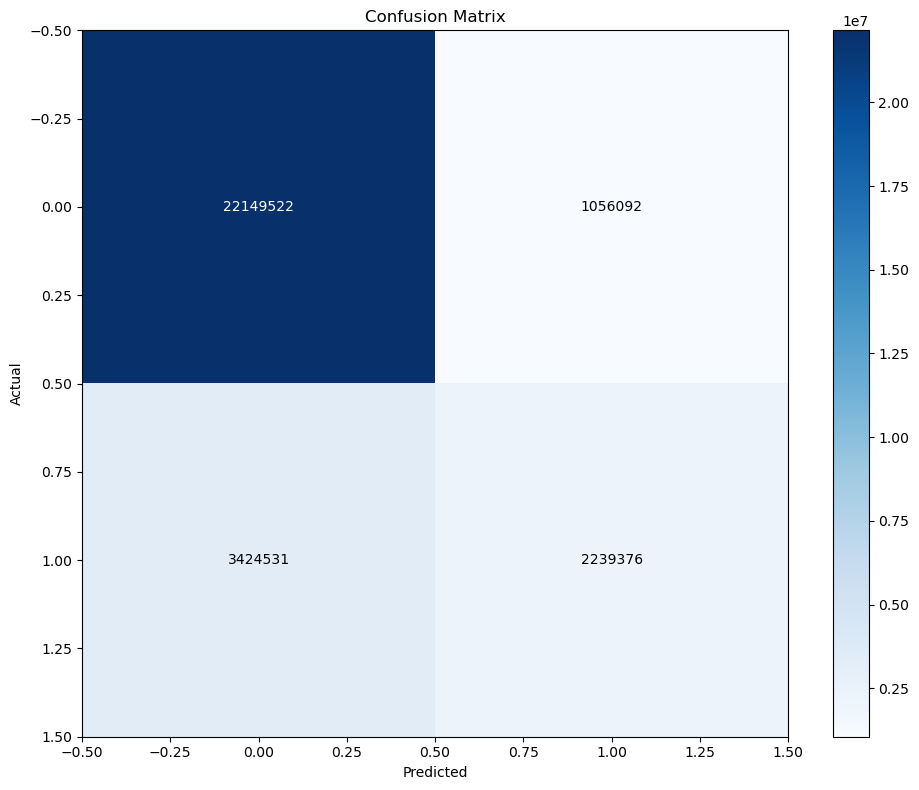

['random_forest_classifier.joblib']

In [8]:

# Evaluate model on validation set
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
y_pred = rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("\nValidation Results:")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Create confusion matrix plot
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred)
plt.imshow(cm, cmap='Blues')
plt.colorbar()

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), 
                ha='center', va='center',
                color='white' if cm[i, j] > cm.max()/2 else 'black')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Save model to disk
joblib.dump(rf_model, 'random_forest_classifier.joblib')


In [9]:
# Delete some more unused variables once we are done with them
del X, X_train, X_val, y, y_train, y_pred, y_val

In [10]:
# Load and preprocess new image
import rioxarray as rio
import xarray as xr
import numpy as np
from joblib import load

# Load the trained model
model = load('random_forest_classifier.joblib')

# Open all images in the working directory
import glob
import os

# Get list of all .tif files in the working directory
tif_files = glob.glob('./working_dir/median_pixels_*.tif')

# Loop through each file
for tif_file in tif_files:
    print(f"Processing {os.path.basename(tif_file)}...")
    image = rio.open_rasterio(tif_file)

    # Reshape for prediction (same as training data)
    n_bands = image.shape[0]
    height = image.shape[1]
    width = image.shape[2]

    # Reshape to 2D array where each row is a pixel
    X_new = image.values.reshape(n_bands, -1).T
    X_new = X_new.astype(np.uint8)

    # Make predictions
    predictions = model.predict(X_new)

    # Reshape predictions back to image dimensions
    prediction_map = predictions.reshape(height, width)

    # Create new xarray DataArray with predictions
    # Only use spatial coordinates from the original image
    spatial_coords = {dim: image.coords[dim] for dim in ['y', 'x']}
    prediction_da = xr.DataArray(
        prediction_map.astype(np.uint8),
        coords=spatial_coords,
        dims=('y', 'x')
    )

    # Save prediction map as GeoTIFF
    output_filename = os.path.basename(tif_file)
    output_path = os.path.join('./working_dir/prediction_maps', f'pred_{output_filename}')
    prediction_da.rio.to_raster(output_path, dtype=np.uint8, compress = 'LZW')

    print(f"Prediction map saved as {output_path}")


Processing median_pixels_2017-06-01_2017-08-31.tif...


C:\Users\linna\AppData\Local\Temp\ipykernel_19712\3896092133.py:29: RuntimeWarning: invalid value encountered in cast
  X_new = X_new.astype(np.uint8)
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  3.7min finished


Prediction map saved as ./working_dir/prediction_maps\pred_median_pixels_2017-06-01_2017-08-31.tif
Processing median_pixels_2018-06-01_2018-08-31.tif...


C:\Users\linna\AppData\Local\Temp\ipykernel_19712\3896092133.py:29: RuntimeWarning: invalid value encountered in cast
  X_new = X_new.astype(np.uint8)
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  3.5min finished


Prediction map saved as ./working_dir/prediction_maps\pred_median_pixels_2018-06-01_2018-08-31.tif
Processing median_pixels_2019-06-01_2019-08-31.tif...


C:\Users\linna\AppData\Local\Temp\ipykernel_19712\3896092133.py:29: RuntimeWarning: invalid value encountered in cast
  X_new = X_new.astype(np.uint8)
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  3.2min finished


Prediction map saved as ./working_dir/prediction_maps\pred_median_pixels_2019-06-01_2019-08-31.tif
Processing median_pixels_2020-06-01_2020-08-31.tif...


C:\Users\linna\AppData\Local\Temp\ipykernel_19712\3896092133.py:29: RuntimeWarning: invalid value encountered in cast
  X_new = X_new.astype(np.uint8)
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  3.3min finished


Prediction map saved as ./working_dir/prediction_maps\pred_median_pixels_2020-06-01_2020-08-31.tif
Processing median_pixels_2021-06-01_2021-08-31.tif...


C:\Users\linna\AppData\Local\Temp\ipykernel_19712\3896092133.py:29: RuntimeWarning: invalid value encountered in cast
  X_new = X_new.astype(np.uint8)
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  3.4min finished


Prediction map saved as ./working_dir/prediction_maps\pred_median_pixels_2021-06-01_2021-08-31.tif
